In [1]:
import rdkit

import pandas as pd
import numpy as np
from copy import deepcopy

from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem

In [2]:
import custom_classification_functions
import custom_models
from custom_classification_functions import *
from custom_models import *
import custom_general_functions
from custom_general_functions import *

In [3]:
from torch_geometric.nn import global_mean_pool, global_max_pool

model_type = "GNN"

filename_basic = "results_classification/model_gnn_conv_no_ust"

apply_scaffold_split = False

hidden_channels=[64]
gcn_layers=4
linear_sizes=[]
aggregations=[global_mean_pool, global_max_pool]
apply_random_aggregations=False

learning_rate=0.001

In [4]:
data, data_y = load_hiv()

pytorch_graph_list = create_pytorch_graph(data)

processed_data = process_pytorch_graph(pytorch_graph_list, data_y)

In [5]:
data

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


In [6]:
processed_data

[Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1]),
 Data(x=[39, 9], edge_index=[2, 88], edge_attr=[88, 3], smiles='C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1', y=[1, 1]),
 Data(x=[21, 9], edge_index=[2, 48], edge_attr=[48, 3], smiles='CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21', y=[1, 1]),
 Data(x=[24, 9], edge_index=[2, 50], edge_attr=[50, 3], smiles='Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1', y=[1, 1]),
 Data(x=[10, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='O=S(=O)(O)CCS(=O)(=O)O', y=[1, 1]),
 Data(x=[16, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles='CCOP(=O)(Nc1cccc(Cl)c1)OCC', y=[1, 1]),
 Data(x=[10, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='O=C(O)c1ccccc1O', y=[1, 1]),
 Data(x=[18, 9], edge_index=[2, 38], edge_attr=[38, 3], smiles='CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O', y=[1, 1]),
 Data(x=[26, 9], edge_index=[2, 54], edge_attr=[54, 3], smile

In [7]:

train_dataset, test_dataset, val_dataset = create_train_test_graphs(processed_data, train_percentage= 0.8, apply_scaffold_split = apply_scaffold_split )
loader, test_loader = create_dataloader(train_dataset, test_dataset, batch_size=64)

j:\Anaconda3\envs\newest_dgl\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
smilestr = [x.smiles for x in train_dataset.dataset]

In [9]:
smilestr

['CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2',
 'C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3)CC(c3ccccc3)=[O+]2)[O+]=C(c2ccccc2)C1',
 'CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21',
 'Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1',
 'O=S(=O)(O)CCS(=O)(=O)O',
 'CCOP(=O)(Nc1cccc(Cl)c1)OCC',
 'O=C(O)c1ccccc1O',
 'CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O',
 'O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1',
 'O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-]',
 'CC(C)(CCC(=O)O)CCC(=O)O',
 'O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1',
 'O=C(O)c1ccccc1SSc1ccccc1C(=O)O',
 'CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1',
 'Sc1cccc2c(S)cccc12',
 'CCOP(N)(=O)c1ccccc1',
 'NNP(=S)(NN)c1ccccc1',
 'O=P(Nc1ccccc1)(Nc1ccccc1)Nc1ccccc1',
 'O=C1C(O)=C(CCCc2ccc(Oc3ccccc3)cc2)C(=O)c2ccccc21',
 'CC(C)N(C(C)C)P(=O)(OP(=O)(c1ccc([N+](=O)[O-])cc1)N(C(C)C)C(C)C)c1ccc([N+](=O)[O-])cc1',
 'c1ccc2c(c1)Sc1ccccc1S2',
 'CC(C)CCS(=O)(=O)O',
 'Cc1ccccc1NC(=N)Nc1ccccc1C',
 'CCCNP(=S)(NCCC)NCCC',


In [10]:
for entry in loader:
    print(entry)

DataBatch(x=[1443, 9], edge_index=[2, 3078], edge_attr=[3078, 3], smiles=[64], y=[64, 1], batch=[1443], ptr=[65])
DataBatch(x=[1607, 9], edge_index=[2, 3490], edge_attr=[3490, 3], smiles=[64], y=[64, 1], batch=[1607], ptr=[65])
DataBatch(x=[1653, 9], edge_index=[2, 3596], edge_attr=[3596, 3], smiles=[64], y=[64, 1], batch=[1653], ptr=[65])
DataBatch(x=[1551, 9], edge_index=[2, 3344], edge_attr=[3344, 3], smiles=[64], y=[64, 1], batch=[1551], ptr=[65])
DataBatch(x=[1549, 9], edge_index=[2, 3336], edge_attr=[3336, 3], smiles=[64], y=[64, 1], batch=[1549], ptr=[65])
DataBatch(x=[1618, 9], edge_index=[2, 3498], edge_attr=[3498, 3], smiles=[64], y=[64, 1], batch=[1618], ptr=[65])
DataBatch(x=[1761, 9], edge_index=[2, 3768], edge_attr=[3768, 3], smiles=[64], y=[64, 1], batch=[1761], ptr=[65])
DataBatch(x=[1654, 9], edge_index=[2, 3558], edge_attr=[3558, 3], smiles=[64], y=[64, 1], batch=[1654], ptr=[65])
DataBatch(x=[1775, 9], edge_index=[2, 3798], edge_attr=[3798, 3], smiles=[64], y=[64, 1]

In [11]:
from padelpy import from_smiles


In [12]:
model, device, optimizer, loss_fn = initialize_classification_model(input_dim=pytorch_graph_list[0][-1].x.shape[-1], hidden_channels=hidden_channels, gcn_layers=gcn_layers, linear_sizes=linear_sizes, aggregations=aggregations, apply_random_aggregations=apply_random_aggregations, learning_rate=0.001)

GCN_molecule_classification(
  (convs): ModuleList(
    (0): GCNConv(9, 64)
    (1-3): 3 x GCNConv(64, 64)
  )
  (activation1): ReLU()
  (activation2): ReLU()
  (additional_layers): ModuleList()
  (out): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters:  13249


Epoch 0 | Train Loss 0.1622325279686636 | Validation Loss 0.14814736922235452 | Validation accuracy 0.9657218992248062
Epoch 10 | Train Loss 0.14234300347641834 | Validation Loss 0.14196750556313714 | Validation accuracy 0.9654012767897856
Epoch 20 | Train Loss 0.13642278230631524 | Validation Loss 0.12903941402486127 | Validation accuracy 0.9675387596899225
Epoch 30 | Train Loss 0.13062463784319103 | Validation Loss 0.1491180966904228 | Validation accuracy 0.9657218992248062
Epoch 40 | Train Loss 0.12722831055232622 | Validation Loss 0.12992824648701867 | Validation accuracy 0.9659926470588235
Epoch 50 | Train Loss 0.12261680241818856 | Validation Loss 0.12401926765839259 | Validation accuracy 0.9693698700410397
Epoch 60 | Train Loss 0.11890775426426559 | Validation Loss 0.11952237604373647 | Validation accuracy 0.9705668604651163
Epoch 70 | Train Loss 0.11557186760587021 | Validation Loss 0.12017542858745238 | Validation accuracy 0.9700823643410853
Epoch 80 | Train Loss 0.11236702918

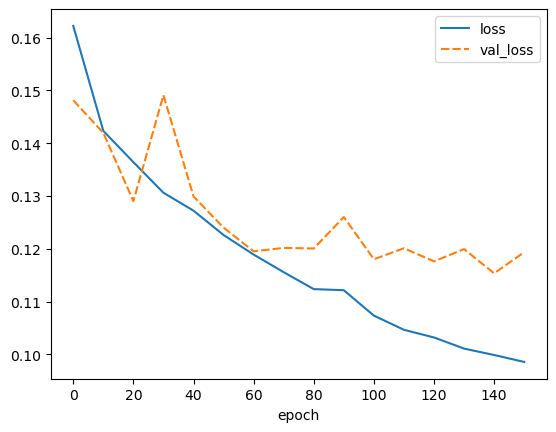

In [13]:
model, best_model_weights, losses, val_losses = classification_train(model, loader, test_loader, device, loss_fn, optimizer, log_time=10, max_epochs=1000, apply_early_stopping = True, early_stopping_patience = 50, finally_plot_losses = True)

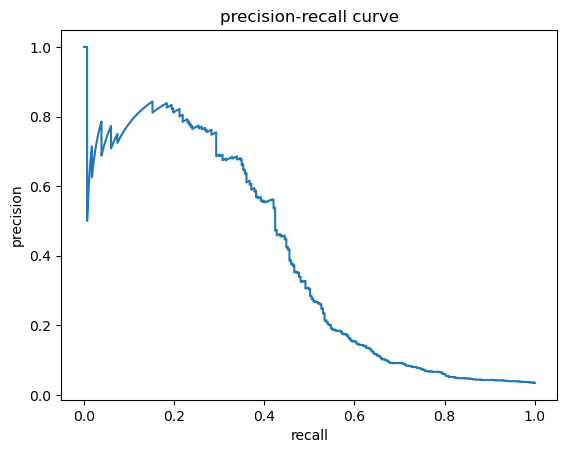

In [14]:
precisions, recalls, thresholds, dfs = predict_classification(model, test_loader, device)

In [34]:
from scipy.special import expit
def predict_classification_ext(model, test_loader, device, best_model_weights=None, plot_final = True, plot_label="precision-recall curve"):

    dfs = []

    test_true_labels = []
    test_predicted_labels = []

    #load best model
    if best_model_weights is not None:
        print("best weights loaded")
        model.load_state_dict(best_model_weights)

    for test_batch in test_loader:
        with torch.no_grad():
            test_true_labels.extend(test_batch.y.int().tolist())


            test_batch.to(device)
            pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 

            y_pred = expit(pred.detach().cpu().numpy().flatten())

            df = pd.DataFrame()
            df["y_real"] = test_batch.y.tolist()
            df["y_pred"] = y_pred

            df["y_real"] = df["y_real"]#.apply(lambda row: row[0])
            df["y_pred"] = df["y_pred"]#.apply(lambda row: row[0])
            dfs.append(df)


            test_predicted_labels.extend(y_pred)


    precisions, recalls, thresholds = precision_recall_curve(np.array(test_true_labels).flatten(), np.array(test_predicted_labels).flatten(), drop_intermediate=True)

    if plot_final:
        plt.plot(recalls, precisions)
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title(plot_label)


    return precisions, recalls, thresholds, dfs


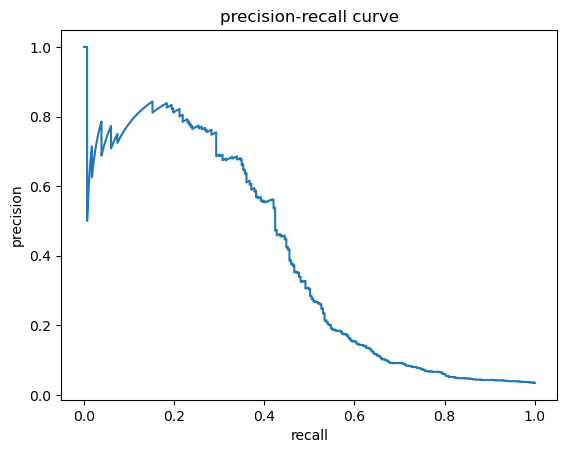

In [35]:
precisions, recalls, thresholds, dfs = predict_classification_ext(model, test_loader, device)

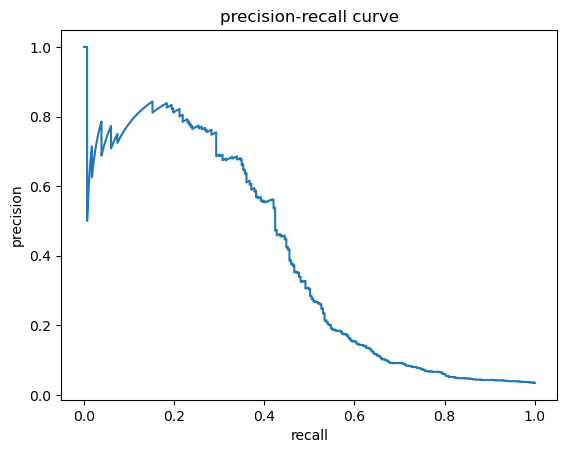

In [27]:
precisions, recalls, thresholds, dfs = predict_classification_ext(model, test_loader, device)

In [25]:
dfs

[    y_real    y_pred
 0      0.0 -4.171771
 1      0.0 -5.282804
 2      0.0 -6.736725
 3      1.0 -4.558479
 4      0.0 -5.325207
 ..     ...       ...
 59     0.0 -5.662138
 60     0.0 -4.436196
 61     0.0 -3.555199
 62     0.0 -5.048340
 63     1.0 -0.663470
 
 [64 rows x 2 columns],
     y_real    y_pred
 0      0.0 -4.289119
 1      0.0 -5.409092
 2      0.0 -4.977692
 3      0.0 -5.164584
 4      0.0 -3.627606
 ..     ...       ...
 59     0.0 -4.256527
 60     0.0 -6.373667
 61     0.0 -2.514364
 62     0.0 -4.009411
 63     0.0 -2.836088
 
 [64 rows x 2 columns],
     y_real    y_pred
 0      0.0 -4.963828
 1      0.0 -4.220079
 2      0.0 -2.229846
 3      0.0 -6.070323
 4      0.0 -4.163435
 ..     ...       ...
 59     0.0 -4.134843
 60     0.0 -5.708528
 61     0.0 -5.982590
 62     0.0 -2.871375
 63     0.0 -4.687963
 
 [64 rows x 2 columns],
     y_real    y_pred
 0      0.0 -7.391017
 1      0.0 -6.322627
 2      0.0 -4.068381
 3      1.0  0.082995
 4      0.0 -6.05849

In [43]:
thresholds

array([1.30816989e-26, 2.91041913e-04, 2.91287579e-04, 4.48080187e-04,
       4.48664883e-04, 5.54727565e-04, 5.54818776e-04, 7.38093688e-04,
       7.40387419e-04, 1.00028620e-03, 1.00242940e-03, 1.07596396e-03,
       1.07716804e-03, 1.10035460e-03, 1.10066449e-03, 1.13087264e-03,
       1.13143073e-03, 1.22778281e-03, 1.22831727e-03, 1.49992341e-03,
       1.50079140e-03, 1.61460089e-03, 1.62153679e-03, 1.72469136e-03,
       1.72671222e-03, 1.79897784e-03, 1.80509000e-03, 1.84300402e-03,
       1.84313464e-03, 1.87729136e-03, 1.87755853e-03, 1.88344484e-03,
       1.88395591e-03, 1.99667271e-03, 1.99753093e-03, 1.99932279e-03,
       2.00037914e-03, 2.43769609e-03, 2.43809144e-03, 2.44495156e-03,
       2.44549965e-03, 2.62634759e-03, 2.62817834e-03, 2.73125386e-03,
       2.73280637e-03, 2.77336221e-03, 2.77444767e-03, 2.77640740e-03,
       2.77791545e-03, 2.82865879e-03, 2.82939454e-03, 3.03223124e-03,
       3.03321891e-03, 3.10664903e-03, 3.10681015e-03, 3.20191705e-03,
      

In [37]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_threshold_index = np.argmax(f1_scores)

best_threshold = thresholds[best_threshold_index]


In [38]:
len(f1_scores)

487

In [39]:
len(precisions)

487

In [40]:
best_threshold_index

326

In [42]:
best_threshold_index

326

In [41]:
best_threshold

0.19270569

In [44]:
precisions[best_threshold_index]

0.5613207547169812

In [45]:
recalls[best_threshold_index]

0.4204946996466431

In [60]:
real_l = np.array([x for x in pd.concat(dfs)["y_real"]]).flatten()

In [57]:
predicted_l = np.array(pd.concat(dfs)["y_pred"])

In [62]:
predicted_labels = (predicted_l >= best_threshold).astype(int)

In [63]:
predicted_labels

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
conf_matrix = confusion_matrix(real_l, predicted_labels)

In [75]:
np.unique(real_l)

array([0., 1.])

In [77]:
predicted_l

array([0.00026364, 0.07275841, 0.02090621, ..., 0.01822601, 0.01548776,
       0.005517  ], dtype=float32)

In [78]:
subset_1 = predicted_l[real_l == 1]
subset_0 = predicted_l[real_l == 0]

(array([6.36950249e+01, 1.97154444e+01, 7.80347349e+00, 3.86838933e+00,
        2.32103360e+00, 1.98755098e+00, 1.05380303e+00, 8.67052439e-01,
        6.66963415e-01, 5.46910432e-01, 4.53535122e-01, 2.00089024e-01,
        3.06803413e-01, 2.00089182e-01, 1.86749609e-01, 1.73410625e-01,
        1.20053509e-01, 1.60071093e-01, 1.86749903e-01, 9.33749517e-02,
        1.20053320e-01, 2.66785576e-02, 5.33571153e-02, 6.66962888e-02,
        6.66963941e-02, 9.33749517e-02, 1.33392788e-02, 1.06714231e-01,
        4.00177101e-02, 8.00356729e-02, 4.00178365e-02, 1.33392788e-02,
        1.33392788e-02, 0.00000000e+00, 2.66784734e-02, 2.66785576e-02,
        2.66785576e-02, 1.33392788e-02, 1.33392788e-02, 2.66785576e-02,
        5.33569468e-02, 1.33392788e-02, 1.33392788e-02, 2.66785576e-02,
        1.33392788e-02, 1.33392788e-02, 0.00000000e+00, 1.33392788e-02,
        1.33392788e-02, 0.00000000e+00, 1.33392788e-02, 1.33392788e-02,
        1.33392367e-02, 1.33393209e-02, 1.33392367e-02, 2.667864

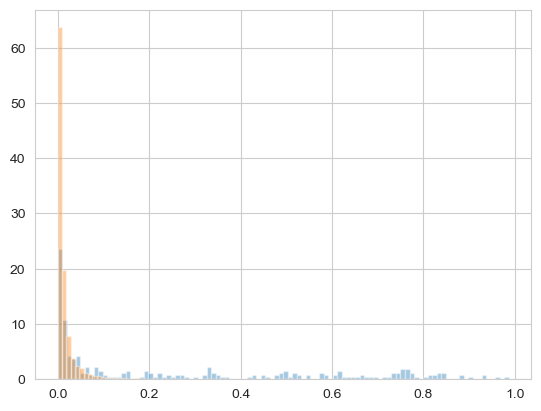

In [115]:
plt.hist(subset_1, density = True, bins=100, alpha=0.4)
plt.hist(subset_0, density = True, bins=100, alpha=0.4)

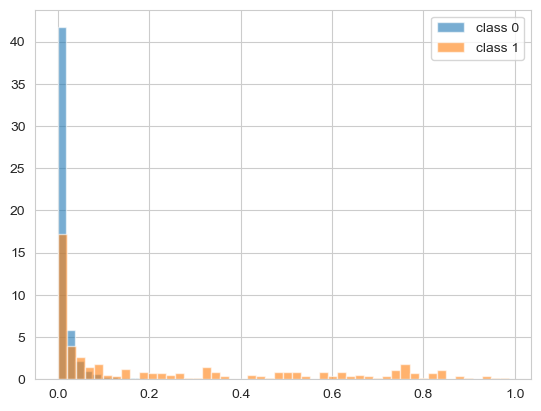

In [119]:
plt.hist(subset_0, density = True, bins=50, alpha=0.6, label="class 0")
plt.hist(subset_1, density = True, bins=50, alpha=0.6, label="class 1")
plt.legend()

In [81]:
import seaborn as sns

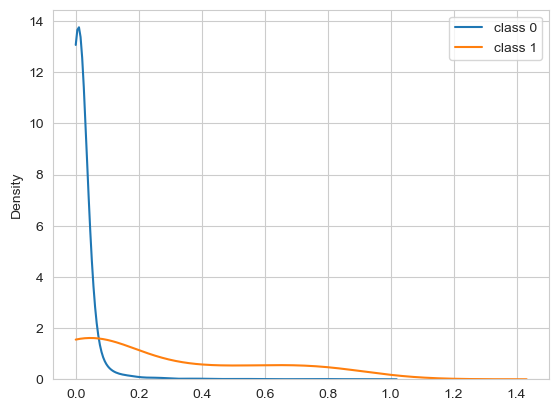

In [112]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(subset_0), clip=(0, None), bw=0.5, label="class 0")
sns.kdeplot(np.array(subset_1), clip=(0, None), bw=0.5, label="class 1")
plt.legend()

In [65]:
conf_matrix

array([[7850,   93],
       [ 164,  119]], dtype=int64)

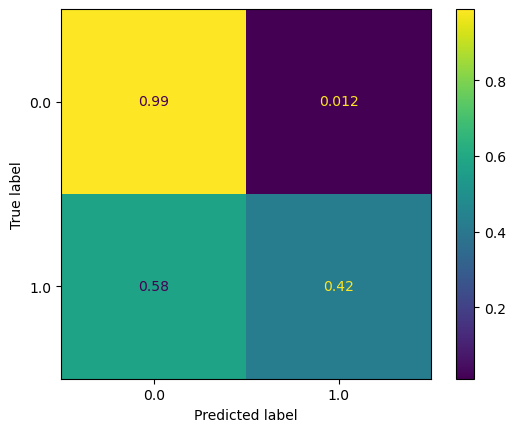

In [66]:
ConfusionMatrixDisplay.from_predictions(real_l, predicted_labels, normalize="true")

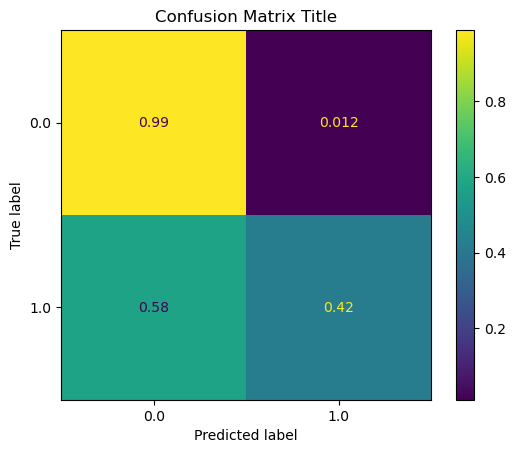

In [72]:
disp = ConfusionMatrixDisplay.from_predictions(real_l, predicted_labels, normalize="true")

disp.ax_.set_title('Confusion Matrix Title')
plt.savefig('confusion_matrix.png')

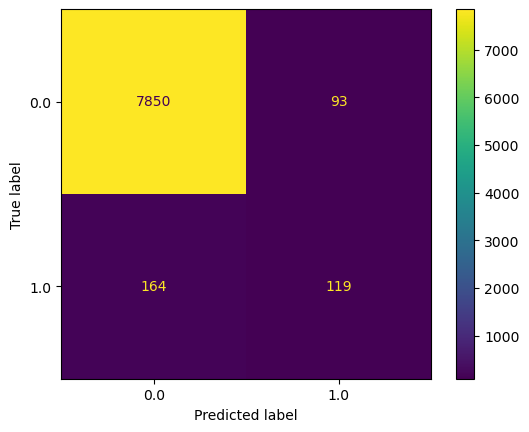

In [70]:
ConfusionMatrixDisplay.from_predictions(real_l, predicted_labels)
plt.savefig('confusion_matrix.png')

In [69]:
plt.savefig('confusion_matrix.png')

<Figure size 640x480 with 0 Axes>